In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

import taichi as ti
ti.init(arch=ti.cpu)


plt.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号


[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.8.8
[Taichi] Starting on arch=x64


# Parameters

In [40]:
N = 501 #agents number
m = 2 #memory length
s = 2 #number of strategies held by each agent
T = 100 #memory of sore function
sigma = np.sqrt(1/(1-(1-1/T)**2))
r = 4 #confidence level( used in CGMG)
L = 0.0 #size of increacement judged by each agent
step = 1000 #total time steps
k0 = 10 #fraction of lambda and N_active

# Make Necessary Functions
### Strategy books: FSS and RSS.
### X[t] and mu[t] and S[t] D[t] denpend on the t-1 step and some other parameters.

In [4]:
#FSS:
def FSS(m):
    P = 2**m
    a = [1,-1]
    sb = np.zeros([2**P,P],dtype=int)
    def generate_permutations(length, current_permutation=[]):
        if length == 0:
            yield current_permutation
        else:
            for value in a:
                for permutation in generate_permutations(length - 1, current_permutation + [value]):
                    yield permutation

    all_permutations = np.array(list(generate_permutations(P)))
    return all_permutations

print(FSS(m))
        

[[ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1 -1  1]
 ...
 [-1 -1 -1 ... -1  1 -1]
 [-1 -1 -1 ... -1 -1  1]
 [-1 -1 -1 ... -1 -1 -1]]


In [5]:
#RSS
'''
def RSS(m):
    a = np.array([[1,1,1,1,1,1,1,1],
                  [-1,-1,-1,-1,1,1,1,1],
                  [-1,-1,1,1,-1,-1,1,1],
                  [1,1,-1,-1,-1,-1,1,1],
                  [1,-1,-1,1,1,-1,-1,1],
                  [1,-1,-1,1,-1,1,1,-1],
                  [-1,1,1,-1,-1,1,1,-1],
                  [-1,1,-1,1,-1,1,-1,1]
                  ])
    b = np.zeros([8,8],dtype=int)
    for i in range(8):
        for j in range(8):
            if a[i][j] ==1:
                b[i][j]=-1
            elif a[i][j]==-1:
                b[i][j]=1
    RSS_strategy_book = np.vstack((a,b))
            
    return RSS_strategy_book

'''
def RSS(m):
    P = 2**m
    origin = FSS(m)
    RSS_sb = np.array([origin[0]])
    RSS_sb[0] = origin[0]
    def if_inco(a,b):
        eq_n = 0
        for i in range(len(a)):
            if a[i] == b[i]:
                eq_n += 1
            else:
                pass
        if eq_n == int(len(a)/2):
            return True
        else:
            return False

    for s_ori in origin:
        judge = True
        for s_cho in RSS_sb:
            if if_inco(s_ori, s_cho):
                judge = judge*True
            else:
                judge = judge*False
        if judge:
            RSS_sb = np.vstack((RSS_sb,s_ori))
            if len(RSS_sb) == P:
                break
        else:
            pass
    anti_RSS_sb = RSS_sb*(-1)
    RSS_sb = np.vstack((RSS_sb,anti_RSS_sb))
    return RSS_sb
     


In [6]:
# D(t), X(t)

#D(t):
def D(strategy):
    '''
    strategy is a list with length N and conponents -1, 1 or 0.
    '''
    D_t = sum(strategy)
    return D_t
    



#X(t) from t-1 step:
def lnX(lnx_tm1, strategy, k0):
    _lambda_ = np.count_nonzero(strategy)*k0
    lnx_t = lnx_tm1 +D(strategy)/_lambda_
    return lnx_t

In [16]:
#mu(t), S(t)

#mu(t):
def mu(mu_tm1, strategy, L, P, k0):    # mu(t)
    def H(x):
        # return  (1 + np.sign(x)) * 1/2
        return 1 if x >= 0 else 0
    _lambda_ = np.count_nonzero(strategy) * k0
    mu_ = 2*mu_tm1 - P * H(mu_tm1-P*0.5)+H(D(strategy)/_lambda_-L)
    return mu_

#S(t):
def S(T,S_tm1, a, strategy, L, k0):
    _lambda_ = np.count_nonzero(strategy) * k0
    if _lambda_ ==0:
        S_ = (1-1/T)*S_tm1
    else:
        # S_ = (1-1/T)*S_tm1 - a* np.sign((D(strategy)/_lambda_-L)) #  * (D(strategy)/_lambda_-L)
        S_ = (1-1/T)*S_tm1 - a* ((D(strategy)/_lambda_-L))
        # print(a* ((D(strategy)/_lambda_-L)))
        # S_ = (1-1/T)*S_tm1
    
    S_random = np.random.normal(S_, sigma) 
    # print(S_)
    return S_random

In [8]:
#strategy books chosen by agents:
#choose randomly and unchanged:
def choose_sb(strategy_books, N, s):
    import random
    n_sb = np.shape(strategy_books)[0]
    index_sb = set(np.arange(n_sb))
    strategy_hold = np.zeros([N,s], dtype=int)
    for i in range(N):
        # strategy_hold[i] = np.array([np.array(random.sample(index_sb, s)), random.normalvariate(r, 1/(1-(1-1/T)**2))])
        strategy_hold[i] = np.array(random.sample(index_sb, s))
    return strategy_hold


    

# Steps to participate in the buy/sell game for evey agent( I am an agent!)
- I am at t now before I need to decide to buy or sell! What I can see: mu[t], decisions that other agents did at t-1.
- I check my strategy books, s strategy books are used. I don't want to change them.
- I see the mu[t], and strategy books give me s behaviors that I can act at t, or I can chooce to skip over. How should I decide?
- I see the S[t] of each of my strategy books, which can be calculated by S[t-1] and decisions that other agents did at t-1. 
- I see the max S[t], and see if it is more than r? If so, I will choose the related strategy book, and obey the behavior it offers me. If not, I won't participate in!
- Every agent like me will do the same steps, then there will be a decision list done by everyone at t. New X[t+1], mu[t+1]...
- I go to the t+1, and everything continue...

In [44]:
def buy_sell_game(t_end, k0):
    global N, m, s, r, T, L
    index_N = np.arange(N)    # 标记agent？
    t_range = np.arange(0,t_end)  # 时间序列
    #strategy_books = FSS(m)
    strategy_books = RSS(m)  
    strategy_hold = choose_sb(strategy_books, N, s)    # 所有agents拥有的strategies
    lnX_list = np.zeros(t_end)  # 价格履历
    lnX_list[0] = np.log(10)
    mu_list = np.zeros(t_end, dtype = int)  # 价格履历（二进制变为十进制）
    Score = r * np.ones([N,s], dtype=float)  # 初始化S  记录每一个agent每一份strategy的分数
    
    # Score = np.random.normal(loc = r, scale =  np.sqrt(1/(1-(1-1/T)**2)), size = (N,s))  # 试图产生一个随机的开始 
    strategy = np.ones([N,t_end], dtype=int)  # 初始化strategy

    D_all = np.zeros(t_end)
    N_active = np.zeros(t_end)
    for t in t_range:
        if t==0:  # 初始情况
            for n in index_N:   # 遍历每一个agent
                for index_s in range(s):  # 遍历agents的每一个strategy
                    strategy_index = strategy_hold[n][index_s]
                    strategy_s = strategy_books[strategy_index]  
                    Score[n][index_s] = S(T,Score[n][index_s], strategy_s[mu_list[t]], [], L, k0)
                Score_max_index = np.argmax(Score[n])
                Score_max = Score[n][Score_max_index]
                if Score_max>=r:
                    strategy_index_chosen = strategy_hold[n][Score_max_index]#选择最大分数的策略
                    strategy_s_chosen = strategy_books[strategy_index_chosen][mu_list[t]]
                    strategy[n,0] = strategy_s_chosen
                else:
                    strategy[n,0] = 0#不参加
        else:
            lnX_list[t] = lnX(lnX_list[t-1], strategy[:,t-1], k0)
            mu_list[t] = mu(mu_list[t-1], strategy[:,t-1], L, 2**m, k0)
            D_i = np.sum(strategy[:,t-1])
            D_all[t] = D_i
            for n in index_N:
                for index_s in range(s):
                    strategy_index = strategy_hold[n][index_s]
                    strategy_s = strategy_books[strategy_index]
                    Score[n][index_s] = S(T,Score[n][index_s], strategy_s[mu_list[t]], strategy[:,t-1], L, k0)
                    
                Score_max_index = np.argmax(Score[n])
                Score_max = Score[n][Score_max_index]
                if Score_max>=r:
                    strategy_index_chosen = strategy_hold[n][Score_max_index] #选择最大分数的策略
                    strategy_s_chosen = strategy_books[strategy_index_chosen][mu_list[t]]
                    strategy[n,t] = strategy_s_chosen
                else:
                    strategy[n,t] = 0 # 不参加
            
            
            N_active[t] = np.count_nonzero(strategy[:,t])
        # print(Score)
        
    #plot figures

    fig, ax1 = plt.subplots(figsize=(20.0, 6.0))
    plt.xticks(rotation=45)
 
    ax1.plot(t_range, np.exp(lnX_list))
    ax1.set_xlabel("t")
    ax1.set_ylabel("x")
    plt.ylim(0,max(np.exp(lnX_list))+1)
    
    ax2 = ax1.twinx()
    ax2.bar(t_range,N_active, width = 1, bottom=0, color = "grey", alpha = 0.5)
    ax2.set_ylabel(r"$V$")
 
    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)



    plt.title(r'x&V-t,(L={},s={},m={},$k_0$={})'.format(L, s, m, k0))
    plt.savefig('x&V-t, (L={},s={},m={},k_0={}.png'.format(L, s, m, k0), dpi = 300)
    # plot_Dx(strategy)
    return lnX_list, strategy, D_all


    

# Culculate some statistical results
- N_active
- the distribution of Deltax
- the correlation between Deltax and x itself


In [10]:
# N_active
def plot_N_active(strategy):
    N_active_list = np.zeros(step)
    for t in range(step):
        strategy_i = strategy[:,t]
        N_active_list[t] = np.count_nonzero(strategy_i)
    t_range = np.arange(step)
    plt.rcParams['figure.figsize'] = (20.0, 6.0)
    plt.bar(t_range, N_active_list, align='center', alpha = 0.5)
    plt.xlabel('t')
    plt.ylabel('N_active')
    plt.title('N_active-t plot')
    plt.show()
    




In [11]:
# distribution
def distribution(x_list, k0):  
    delta_x_list = np.zeros(step-1)
    for i in range(step-1):
        delta_x_list[i] = x_list[i+1] - x_list[i]
    delta_x_min = min(delta_x_list)
    delta_x_max = max(delta_x_list)
    d_deltax = (delta_x_max-delta_x_min)/50
    delta_x_range = np.linspace(delta_x_min,delta_x_max, 50)
    distribute_n = np.zeros(50)
    for i in range(49):
        dx_min = delta_x_range[i]
        dx_max = delta_x_range[i+1]
        delta_x_list_copy = delta_x_list[:]
        for deltax in delta_x_list_copy:
            if (deltax>=dx_min) and (deltax<dx_max):
                distribute_n[i]+=1#落在区间的计数
                delta_x_list = np.delete(delta_x_list, np.where(delta_x_list == deltax)) #删掉计数的
            else:
                pass
    distribute_n[-1] = len(delta_x_list)#剩下的
    

    fig, ax1 = plt.subplots(figsize=(8.0, 6.0))
    # plt.rcParams['figure.figsize'] = (8.0, 6.0)
    ax1.bar(delta_x_range, distribute_n, width=d_deltax, align='center', alpha = 0.5)
    plt.xlabel(r'$delta_x$')
    plt.ylabel(r'$p_{\Delta x}$')
    plt.title(r'distribution of deltax, (L={},s={},m={},$k_0$={})'.format(L, s, m, k0))
    # plt.show()
    plt.savefig('distribution of deltax, (L={},s={},m={},$k_0$={}.png'.format(L, s, m, k0), dpi = 300)

        


In [12]:
#stylised facts: fat tail
import scipy.stats as st
def QQ_plot(data_list, k0):
    # 计算标准正态分位数，分别为0, 1/10, 2/20,..., 10/10
    quantiles = st.norm.ppf(np.linspace(0.01, 0.99, len(data_list)))
    # 对原始数据排序
    data_sort = np.sort(data_list)

    fig = plt.figure(figsize=(8.0, 6.0))
    plt.scatter(quantiles, data_sort, s = 1, color='r')
    plt.xlabel('Quantiles of normal distribution') # 设置横坐标名称

    plt.ylabel('Quantiles of data') # 设置纵坐标名称

    # 绘制理论分位数直线

    line = quantiles * np.std(data_sort) + np.mean(data_sort) # 计算理论分位数直线的纵坐标值

    plt.plot(quantiles, line, 'b--') # 根据标准正态分位数和理论分位数直线的纵坐标值绘制直线，颜色为红色虚线
    # plt.title(f"k = {k0}")
    # plt.savefig(f'QQ_k0={k0}.png', dpi = 300
    # plt.show() # 显示图形
    plt.title(r'QQ,(L={},s={},m={},$k_0$={})'.format(L, s, m, k0))

    plt.savefig('QQ, (L={},s={},m={},k_0={}.png'.format(L, s, m, k0), dpi = 300)

In [13]:
#correlation function
def rho(x_list, Delta_T):
    n = len(x_list)
    xi_ave = np.average(x_list[:(n-Delta_T)])
    if xi_ave == 0:
        xi_ave = 0.001
    xipt_ave = np.average(x_list[Delta_T:])
    if xipt_ave == 0:
        xipt_ave = 0
    xx = 0
    for i in range(n - Delta_T):
        xx_i = (x_list[i]-xi_ave) *( x_list[i + Delta_T] -xipt_ave) 
        xx  += xx_i
    cov = xx/(n - Delta_T - 1)
    var_xi = np.sqrt(np.average(x_list[:(n-Delta_T)]**2) - xi_ave**2)
    var_xipt = np.sqrt(np.average(x_list[Delta_T:]**2) - xipt_ave**2)
    return xx/(n-1)/(var_xi*var_xipt)

def correlation_function(a_list,a_name,b_name, k0, d):   

    # cor_list = np.array([])
    # for i in np.arange(int(step/10)):
    #     a_list_bin = a_list[10*i:(10*i+9)]
    #     b_list_bin = b_list[10*i:(10*i+9)]
    #     cor = np.correlate(a_list_bin, b_list_bin)
    #     cor_list = np.append(cor_list, cor)
    step_list = np.arange(0, int(step/d)-1, 1)
    cor_list = np.array([])
    for i in step_list:
        rho_i = rho(a_list, i)
        cor_list = np.append(cor_list, rho_i)
   
    # cor_var = np.sqrt(np.sum(cor_list**2)/len(cor_list) - (np.sum(cor_list))/len(cor_list)**2)
    # if cor_var != 0:
    #     cor_list = cor_list/cor_var
    plt.figure(figsize=(8.0, 6.0))
    # plt.rcParams['figure.figsize'] = (8.0, 6.0)
    plt.scatter(step_list, cor_list, s = 5, marker= 'o', color = 'r')
    # plt.scatter(step_list, cor_list, marker = 'o', color = 'r')
    
    plt.xlabel('t')
    # plt.title(r'correlation function of {} and {}, $k_0$ = {}'.format(a_name,b_name, k0 ))
    plt.ylabel('autocorrelation coefficient')
    # plt.savefig(f'correlation_func_k0={k0}.png', dpi = 300)
    plt.title(r'autocorrelation of {},(L={},s={},m={},$k_0$={})'.format(a_name, L, s, m, k0))
    plt.savefig('autocorrelation of {}, (L={},s={},m={},k_0={}).png'.format(b_name, L, s, m, k0), dpi = 300)

In [14]:
# volatility
def volatility(D_list, n):
    Length_D = len(D_list)
    D_v_list = np.zeros(Length_D)
    for D_ in range(0, Length_D-n):
        DS = D_list[D_: D_+n]
        D_v_list[D_] = np.sqrt((np.sum(DS**2))/n - (np.sum(DS)/n)**2)
    return D_v_list



# Calculation

No handles with labels found to put in legend.
<ipython-input-13-6671790e6d4a>:17: RuntimeWarning: invalid value encountered in double_scalars
  return xx/(n-1)/(var_xi*var_xipt)
<ipython-input-13-6671790e6d4a>:14: RuntimeWarning: invalid value encountered in double_scalars
  cov = xx/(n - Delta_T - 1)


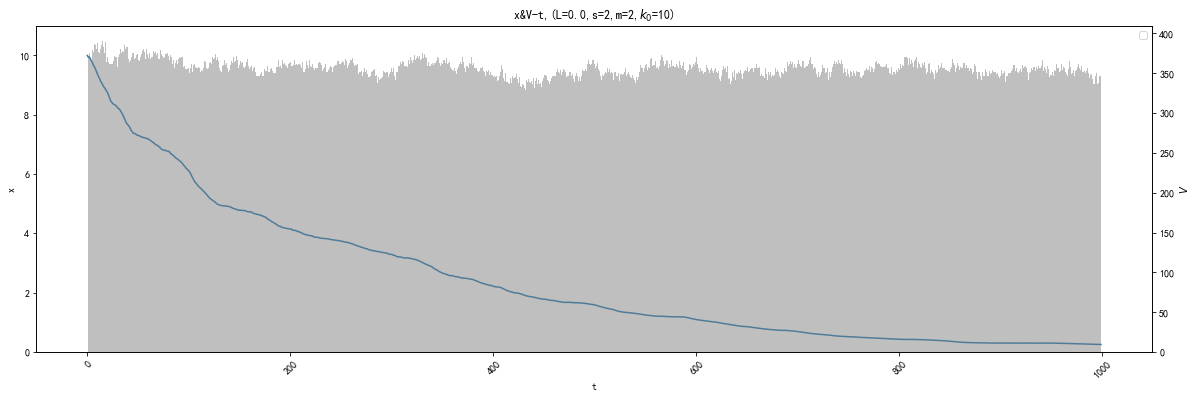

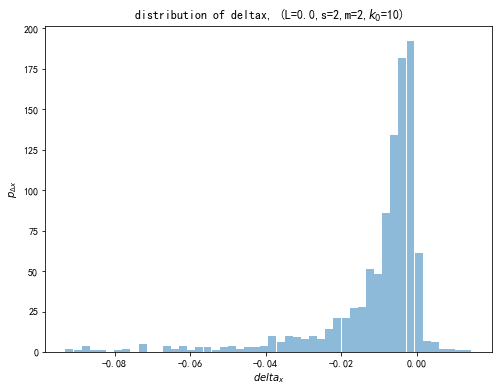

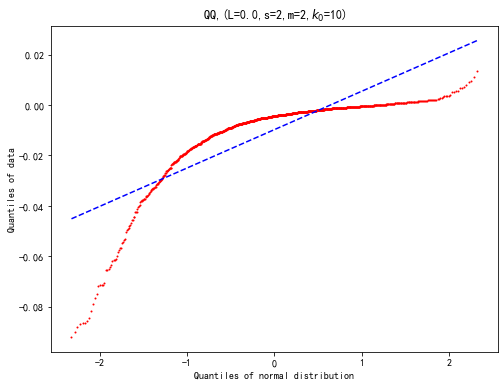

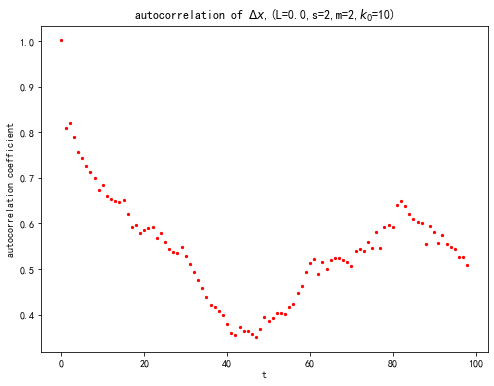

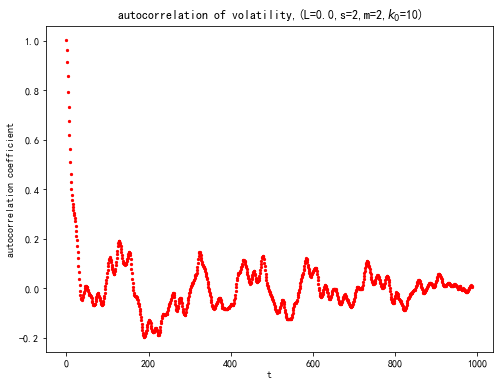

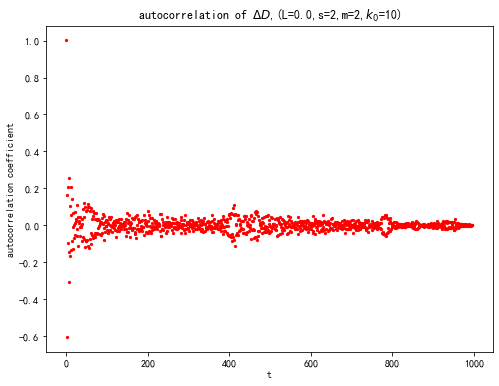

In [45]:
for k in [10]:    
    lnX_list, strategy, D_list = buy_sell_game(step, k)
    x_list = np.exp(lnX_list)

    deltax_list = np.array([x_list[i+1]-x_list[i] for i in range(step-1)])
    deltaD_list = np.array([D_list[i+1]-D_list[i] for i in range(step-1)])
    

    distribution(x_list, k)
    QQ_plot(deltax_list, k)
    correlation_function(deltax_list, r'$\Delta x$', 'delta_x',   k, 10)
    volatility_list = volatility(D_list, 10) 
    deltaV_list = np.array([volatility_list[i+1]-volatility_list[i] for i in range(step-1)])
    correlation_function(volatility_list, 'volatility', 'volatility',  k, 1)
    correlation_function(deltaD_list, r'$\Delta D$', 'delta_D',  k, 1)

    # plt.plot(np.arange(step),x_list,c='r')

In [36]:
# for k in np.arange(1, 1000, 200):    
#     lnX_list, strategy, D_list = buy_sell_game(step, k)
#     x_list = np.exp(lnX_list)

#     deltax_list = np.array([x_list[i+1]-x_list[i] for i in range(step-1)])
#     distribution(x_list, k)
#     QQ_plot(deltax_list, k)
#     correlation_function(deltax_list,  'x','y', k, 5)
#     volatility_list = volatility(D_list, 10) 
#     correlation_function(volatility_list,  'x_v','y_v', k, 1)
#     # plt.plot(np.arange(step),x_list,c='r')


# Advanced simulation consideration
- MM model(4.10 as the score function)
- agent wealth
- time scale

In [36]:
# consider the agent's wealth and use MM:
def buy_sell_game_wealth(tau, k0):
    global N, m, s, T, L, step
    index_N = np.arange(N)
    t_range = np.arange(0,step)
    #strategy_books = FSS(m)
    strategy_books = RSS(m)
    strategy_hold = choose_sb(strategy_books, N, s)
    lnX_list = np.zeros(step)
    lnX_list[0] = 1
    mu_list = np.zeros(step, dtype = int)
    mu_list[0] = 0
    Score = np.zeros([N,s], dtype=float)#初始化S
    strategy = np.zeros([N,step], dtype=int)#初始化strategy
    C_array = np.zeros([N,step])#初始化C
    phi_array = np.zeros([N,step])#初始化phi
    wealth_array = np.zeros([N,step])#初始化W
    D_all = np.zeros(step)
    N_active = np.zeros(step)

    
    for t in t_range:
        
        if t==0:
            x_t = np.exp(lnX_list[t])
            for n in index_N:
                phi_n = 5
                C_n = np.exp(3)
                for index_s in range(s):
                    strategy_index = strategy_hold[n][index_s]
                    strategy_s = strategy_books[strategy_index]
                    # Score[n][index_s] = S_MM(T,t, strategy,mu_list, strategy_s, L, k0)
                    Score[n][index_s] = S(T,Score[n][index_s], strategy_s[mu_list[t]], [], L, k0)
                Score_max_index = np.argmax(Score[n])
                strategy_index_chosen = strategy_hold[n][Score_max_index]#选择最大分数的策略
                strategy_s_chosen = strategy_books[strategy_index_chosen][mu_list[t]]
                if ((strategy_s_chosen==-1) and (phi_n<=0)) or ((strategy_s_chosen==1)and(C_n<x_t)):
                    strategy_s_chosen = 0
                    strategy[n][t] = 0
                else:
                    strategy[n][t] = strategy_s_chosen
                phi_array[n,t] = phi_n + strategy_s_chosen
                C_array[n,t] = C_n - x_t*strategy_s_chosen
                wealth_array[n, t] = C_array[n,t]+phi_array[n,t]*x_t

        else:
            D_i = np.sum(strategy[:,t-1])
        
            D_all[t] = D_i

            N_active[t] = np.count_nonzero(strategy[:,t-1])
            lnX_list[t] = lnX(lnX_list[t-1], strategy[:,t-1], k0)
            # mu_list[t] = mu(mu_list[t-1], strategy[:,t-1], L, 2**m, k0)
            x_t = np.exp(lnX_list[t])
            for n in index_N:
                phi_n = phi_array[n,t-1]
                C_n = C_array[n,t-1]
                for index_s in range(s):
                    strategy_index = strategy_hold[n][index_s]
                    strategy_s = strategy_books[strategy_index]
                    # Score[n][index_s] = S_MM(T,t, strategy,mu_list, strategy_s, L, k0)
                    Score[n][index_s] = S(T,Score[n][index_s], strategy_s[mu_list[t]], strategy[:,t-1], L, k0)
                Score_max_index = np.argmax(Score[n])
                strategy_index_chosen = strategy_hold[n][Score_max_index]#选择最大分数的策略
                strategy_s_chosen = strategy_books[strategy_index_chosen][mu_list[t]]
                if ((strategy_s_chosen==-1) and (phi_n<=0)) or ((strategy_s_chosen==1)and(C_n<x_t)):
                    strategy_s_chosen = 0
                    strategy[n][t] = 0
                else:
                    strategy[n][t] = strategy_s_chosen
                phi_array[n,t] = phi_n + strategy_s_chosen
                C_array[n,t] = C_n - x_t*strategy_s_chosen
                wealth_array[n, t] = C_array[n,t]+phi_array[n,t]*x_t
        if t > tau + m:
            MU_ = 0
            for j in range(m):
                x1 = lnX_list[t-j]
                x2 = lnX_list[t-j-tau]
                delta_lnx = x1-x2 -L
                if delta_lnx > 0:
                    mu_ = 1
                else:
                    mu_ = 0
                MU_ += mu_ * 2 **j
            mu_list[t] = MU_
        
                
    #plot figures
    t_range = np.arange(0,step)
   
    
    
    fig, ax1 = plt.subplots(figsize=(20.0, 6.0))
    plt.xticks(rotation=45)
 
    ax1.plot(t_range, np.exp(lnX_list))
    ax1.set_xlabel("t")
    ax1.set_ylabel("x")

    
    ax2 = ax1.twinx()
    ax2.bar(t_range,N_active, width = 1, bottom=0, color = "grey", alpha = 0.5)
    ax2.set_ylabel(r"V")
 
    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)



    plt.title(r'x&V-t,(L={},s={},m={},$k_0$={})'.format(L, s, m, k0))
    plt.savefig('x&D-t, (L={},s={},m={},k_0={}.png'.format(L, s, m, k0), dpi = 300)
    
   

    # plot_Dx(strategy)
    return lnX_list, strategy, wealth_array, D_all


    

In [25]:
#consider the wealth distribution
def dstri_of_wealth(wealth_list, k0, t):  
    wealth_min = min(wealth_list)
    wealth_max = max(wealth_list)
    delta_wealth = (wealth_max-wealth_min)/20
    wealth_range = np.linspace(wealth_min,wealth_max, 20)
    distribute_n = np.zeros(20)
    for i in range(19):
        w_min = wealth_range[i]
        w_max = wealth_range[i+1]
        w_list_copy = wealth_list[:]
        for w in w_list_copy:
            if (w>=w_min) and (w<w_max):
                distribute_n[i]+=1#落在区间的计数
                wealth_list = np.delete(wealth_list, np.where(wealth_list == w)) #删掉计数的
            else:
                pass
    distribute_n[-1] = len(wealth_list)#剩下的
    

    fig, ax1 = plt.subplots(figsize=(8.0, 6.0))
    # plt.rcParams['figure.figsize'] = (8.0, 6.0)
    ax1.bar(wealth_range, distribute_n, width=delta_wealth, align='center', alpha = 0.5)
    plt.xlabel('w')
    plt.ylabel('p(w)')
    plt.title(r'distribution of w, (L={},s={},m={},$k_0$={},t={})'.format(L, s, m, k0,t))
    # plt.show()
    plt.savefig('distribution of w, (L={},s={},m={},$k_0$={},t={}.png'.format(L, s, m, k0, t), dpi = 300)

        


In [26]:
#consider the wealth distribution
def dstri_of_wealth(wealth_list, k0, t):  
    wealth_min = min(wealth_list)
    wealth_max = max(wealth_list)
    delta_wealth = (wealth_max-wealth_min)/20
    wealth_range = np.linspace(wealth_min,wealth_max, 20)
    distribute_n = np.zeros(20)
    for i in range(19):
        w_min = wealth_range[i]
        w_max = wealth_range[i+1]
        w_list_copy = wealth_list[:]
        for w in w_list_copy:
            if (w>=w_min) and (w<w_max):
                distribute_n[i]+=1#落在区间的计数
                wealth_list = np.delete(wealth_list, np.where(wealth_list == w)) #删掉计数的
            else:
                pass
    distribute_n[-1] = len(wealth_list)#剩下的
    

    fig, ax1 = plt.subplots(figsize=(8.0, 6.0))
    # plt.rcParams['figure.figsize'] = (8.0, 6.0)
    ax1.bar(wealth_range, distribute_n, width=delta_wealth, align='center', alpha = 0.5)
    plt.xlabel('w')
    plt.ylabel('p(w)')
    plt.title(r'distribution of w, (L={},s={},m={},$k_0$={},t={})'.format(L, s, m, k0,t))
    # plt.show()
    plt.savefig('distribution of w, (L={},s={},m={},$k_0$={},t={}.png'.format(L, s, m, k0, t), dpi = 300)

        


No handles with labels found to put in legend.


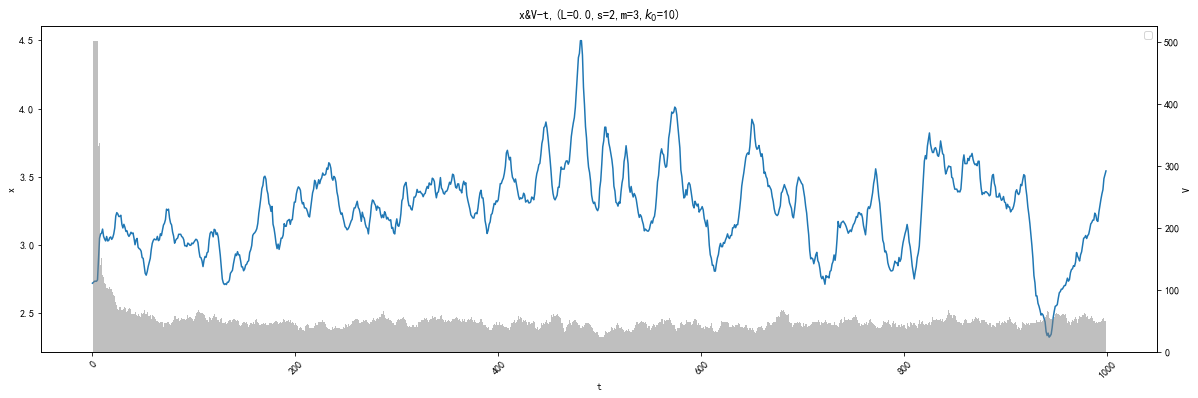

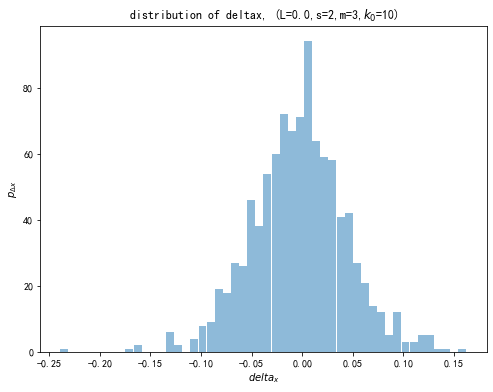

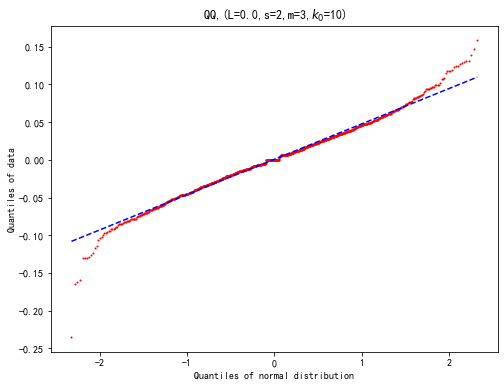

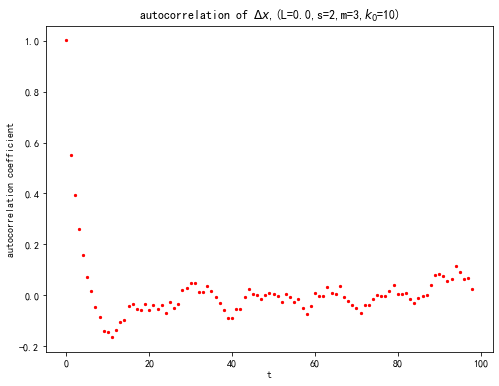

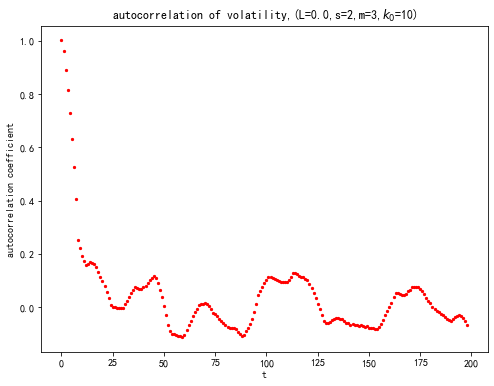

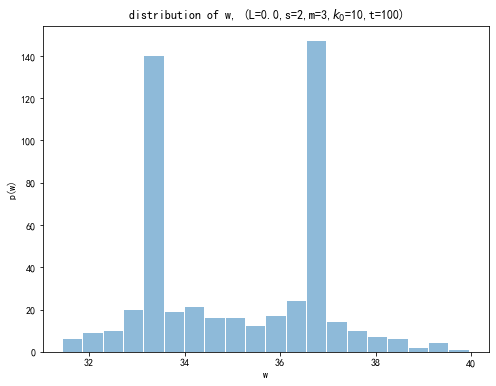

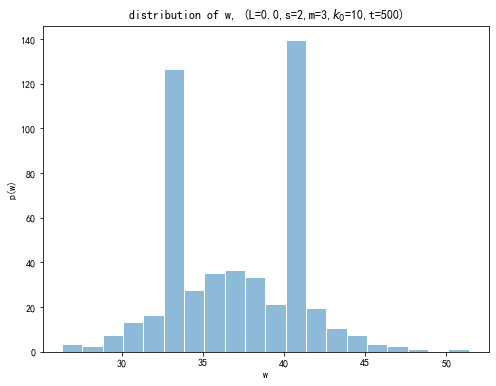

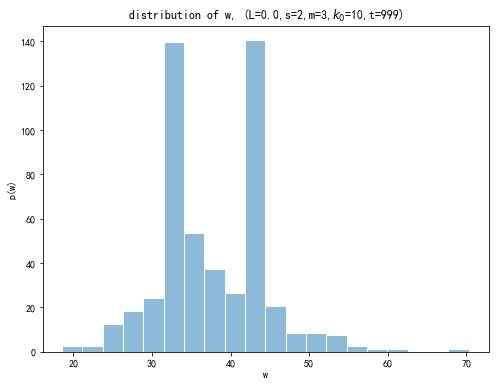

In [39]:
# for k in [0.1, 1, 10, 100]:
k = 10
lnX_list, strategy, wealth_array, D_list = buy_sell_game_wealth(tau = 15, k0 = k)
x_list = np.exp(lnX_list)


deltax_list = np.array([x_list[i+1]-x_list[i] for i in range(step-1)])
distribution(x_list, k)
QQ_plot(deltax_list, k)
correlation_function(deltax_list,  r'$\Delta x$','delta_x', k, 10)
volatility_list = volatility(D_list, 10) 
correlation_function(volatility_list,  'volatility','volatility', k, 5)
wealth_list_100 = wealth_array[:,100]
dstri_of_wealth(wealth_list_100, k, 100)
wealth_list_500 = wealth_array[:,500]
dstri_of_wealth(wealth_list_500, k, 500)
wealth_list_999 = wealth_array[:,999]
dstri_of_wealth(wealth_list_999, k, 999)

**autocorrelation查一下函数 和 QQ plot      
改参数 r **L** k0   
FSS RSS 比较**   
4.10   
timescale   
r 与初始wealth相关   

